In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import yaml
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import shutil
! pip install ultralytics
from ultralytics import YOLO
import cv2

print("Libraries imported successfully.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3

In [2]:
dataset_path = "/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8"
processed_dataset_path = "/kaggle/working/BoneFracture_Preprocessed"


os.makedirs("/kaggle/working/results", exist_ok=True)

print(f"Original dataset path: {dataset_path}")
print(f"Processed dataset will be saved to: {processed_dataset_path}")


for split in ["train", "valid", "test"]:
    os.makedirs(f"{processed_dataset_path}/{split}/images", exist_ok=True)
    os.makedirs(f"{processed_dataset_path}/{split}/labels", exist_ok=True)
print(" Created directories for processed data.")


def preprocess_image(image_path):

    img = cv2.imread(image_path)

    return img


image_files_info = []

for split in ["train", "valid", "test"]:
    images_dir = f"{dataset_path}/{split}/images"
    labels_dir = f"{dataset_path}/{split}/labels"
    output_images_dir = f"{processed_dataset_path}/{split}/images"
    output_labels_dir = f"{processed_dataset_path}/{split}/labels"

    if not os.path.exists(images_dir):
        print(f"Warning: {images_dir} does not exist. Skipping {split} split.")
        continue

    for img_file in tqdm(os.listdir(images_dir), desc=f"Processing {split} images"):
        img_name, img_ext = os.path.splitext(img_file)
        if img_ext.lower() not in ('.jpg', '.jpeg', '.png'):
            continue

        img_path = os.path.join(images_dir, img_file)
        

        processed_img = preprocess_image(img_path)
        cv2.imwrite(os.path.join(output_images_dir, img_file), processed_img)


        h, w = processed_img.shape[:2]
        image_files_info.append({'split': split, 'image_name': img_file, 'width': w, 'height': h})


        label_file = img_name + ".txt" 
        source_label_path = os.path.join(labels_dir, label_file)
        destination_label_path = os.path.join(output_labels_dir, label_file)

        if os.path.exists(source_label_path):
            shutil.copy(source_label_path, destination_label_path)
        else:
            print(f"Warning: Label file {source_label_path} not found for {img_file}")

print("✅ Preprocessing and copying complete!")


all_images_df = pd.DataFrame(image_files_info)
print(f"\nTotal images processed: {len(all_images_df)}")


yaml_path_for_yolo = "/kaggle/working/data.yaml"

yolo_names = ['elbow positive', 'fingers positive', 'forearm fracture',
              'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']

yaml_content = f"""
path: {processed_dataset_path}
train: train/images
val: valid/images
test: test/images

nc: {len(yolo_names)}
names: {yolo_names}
"""

with open(yaml_path_for_yolo, "w") as f:
    f.write(yaml_content)
print(f"✅ data.yaml created at {yaml_path_for_yolo} with correct absolute paths.")

Original dataset path: /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8
Processed dataset will be saved to: /kaggle/working/BoneFracture_Preprocessed
✅ Created directories for processed data.


Processing train images:   0%|          | 0/3631 [00:00<?, ?it/s]

Processing valid images:   0%|          | 0/348 [00:00<?, ?it/s]

Processing test images:   0%|          | 0/169 [00:00<?, ?it/s]

✅ Preprocessing and copying complete!

Total images processed: 4148
✅ data.yaml created at /kaggle/working/data.yaml with correct absolute paths.


# 3. Exploratory Data Analysis (EDA) and Visualization 


Sample images with bounding boxes and segmentation masks from the processed dataset:


/tmp/ipykernel_19/1545751245.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap('viridis', len(class_names))(class_id)[:3]


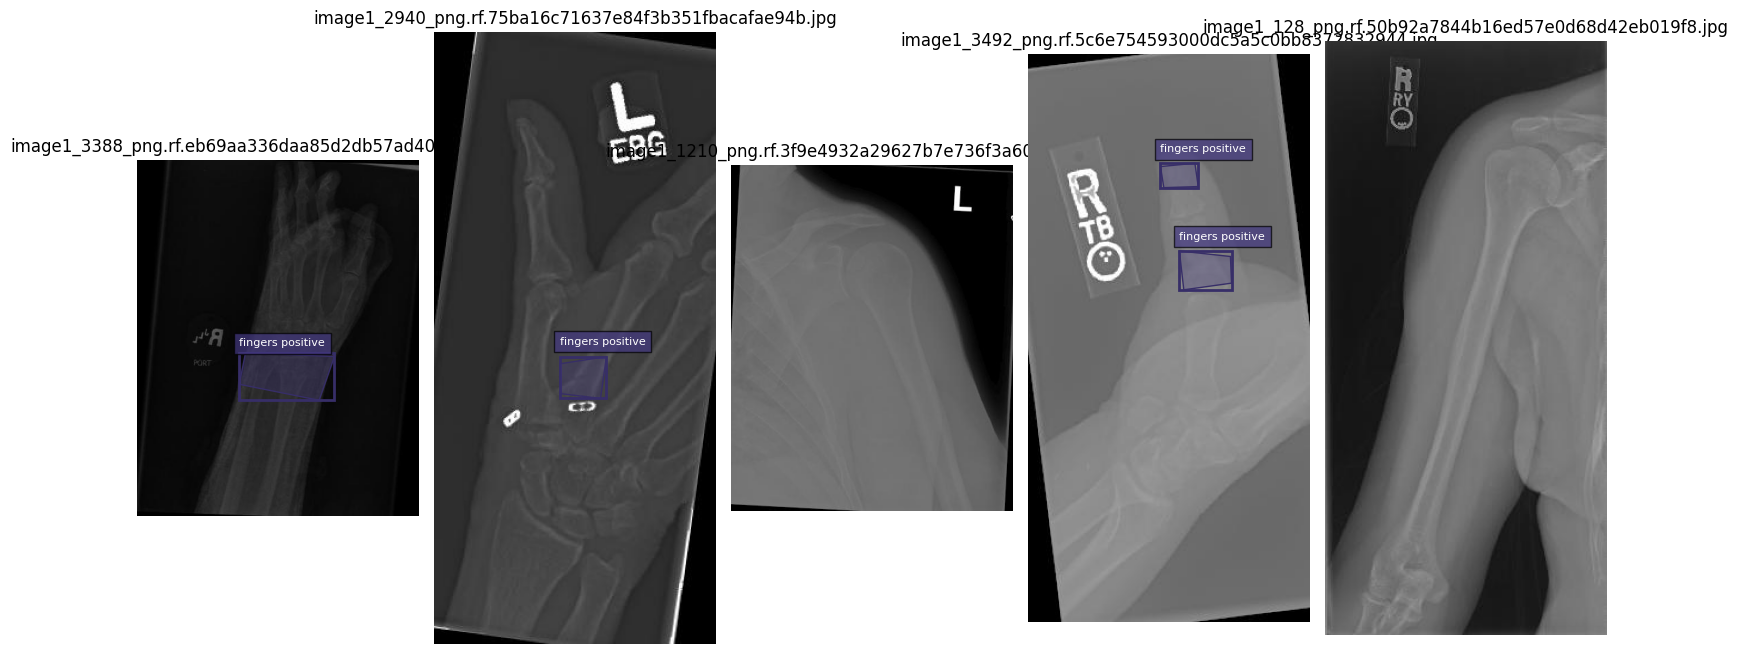

In [3]:
def parse_yolo_annotation(label_path, img_width, img_height):
    boxes = []
    class_ids = []
    polygons = []

    if not os.path.exists(label_path):
        return boxes, class_ids, polygons

    with open(label_path, 'r') as f:
        for line in f:
            parts = list(map(float, line.strip().split()))
            class_id = int(parts[0])


            if len(parts) == 5:
                center_x, center_y, bbox_width, bbox_height = parts[1:]

                xmin = int((center_x - bbox_width / 2) * img_width)
                ymin = int((center_y - bbox_height / 2) * img_height)
                xmax = int((center_x + bbox_width / 2) * img_width)
                ymax = int((center_y + bbox_height / 2) * img_height)

                boxes.append([xmin, ymin, xmax, ymax])
                class_ids.append(class_id)
                polygons.append(None)
            elif len(parts) > 5:

                poly_coords_normalized = np.array(parts[1:]).reshape(-1, 2)
                poly_coords_pixel = (poly_coords_normalized * np.array([img_width, img_height])).astype(np.int32)
                polygons.append(poly_coords_pixel)
                class_ids.append(class_id)
                xmin_poly = np.min(poly_coords_pixel[:, 0])
                ymin_poly = np.min(poly_coords_pixel[:, 1])
                xmax_poly = np.max(poly_coords_pixel[:, 0])
                ymax_poly = np.max(poly_coords_pixel[:, 1])
                boxes.append([xmin_poly, ymin_poly, xmax_poly, ymax_poly])
            else:
                print(f"Warning: Unexpected number of values in annotation line: {line.strip()}")
                continue
    return boxes, class_ids, polygons


def plot_images_with_boxes_yolo(split_dir, num_images=5, class_names=yolo_names):
    images_to_sample = [f for f in os.listdir(os.path.join(split_dir, 'images')) if f.endswith(('.jpg', '.jpeg', '.png'))]
    if not images_to_sample:
        print(f"No images found in {split_dir}/images to sample.")
        return

    sampled_img_files = np.random.choice(images_to_sample, min(num_images, len(images_to_sample)), replace=False)

    plt.figure(figsize=(15, 10))
    for i, img_file in enumerate(sampled_img_files):
        img_path = os.path.join(split_dir, 'images', img_file)
        label_path = os.path.join(split_dir, 'labels', os.path.splitext(img_file)[0] + '.txt')

        img = Image.open(img_path).convert("RGB")
        img_w, img_h = img.size


        boxes, class_ids, polygons = parse_yolo_annotation(label_path, img_w, img_h)

        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(img_file))
        plt.axis('off')

        for j, (box, class_id, polygon) in enumerate(zip(boxes, class_ids, polygons)):
            label = class_names[class_id] if class_id < len(class_names) else f"Class_{class_id}"


            color = plt.cm.get_cmap('viridis', len(class_names))(class_id)[:3]
            edge_color = tuple(np.array(color) * 0.8)


            xmin, ymin, xmax, ymax = box
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 fill=False, edgecolor=edge_color, linewidth=2)
            ax.add_patch(rect)
            

            if polygon is not None and len(polygon) > 0:

                poly_patch = plt.Polygon(polygon, closed=True,
                                         facecolor=color + (0.3,),
                                         edgecolor=edge_color, linewidth=1)
                ax.add_patch(poly_patch)
                
            ax.text(xmin, ymin - 10, label, color='white', fontsize=8,
                    bbox=dict(facecolor=color, alpha=0.7))
    plt.tight_layout()
    plt.show()


print("\nSample images with bounding boxes and segmentation masks from the processed dataset:")
plot_images_with_boxes_yolo(os.path.join(processed_dataset_path, 'train'))

# 4. Model Training (YOLOv8)

In [4]:
model = YOLO('yolov8n.pt')

print("\nStarting model training...")

results = model.train(
    data=yaml_path_for_yolo,
    epochs=50, 
    imgsz=416, 
    batch=32, 
    workers=8,
    name='bone_fracture_detection_yolov8n_fast',
    project='/kaggle/working/runs'
)

print("\nTraining complete!")

100%|██████████| 6.25M/6.25M [00:00<00:00, 79.3MB/s]



Starting model training...
Ultralytics 8.3.145 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=bone_fracture_detection_yolov8n_fast, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience

100%|██████████| 755k/755k [00:00<00:00, 17.0MB/s]


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 71.8MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 510.2±175.2 MB/s, size: 20.7 KB)


train: Scanning /kaggle/working/BoneFracture_Preprocessed/train/labels... 3631 images, 1827 backgrounds, 0 corrupt: 100%|██████████| 3631/3631 [00:02<00:00, 1417.64it/s]


train: New cache created: /kaggle/working/BoneFracture_Preprocessed/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 445.0±228.9 MB/s, size: 15.2 KB)


val: Scanning /kaggle/working/BoneFracture_Preprocessed/valid/labels... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:00<00:00, 1316.94it/s]

val: New cache created: /kaggle/working/BoneFracture_Preprocessed/valid/labels.cache


Plotting labels to /kaggle/working/runs/bone_fracture_detection_yolov8n_fast/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to /kaggle/working/runs/bone_fracture_detection_yolov8n_fast
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.69G      3.045      5.628      2.201         17        416: 100%|██████████| 114/114 [00:20<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


                   all        348        204   0.000707      0.307    0.00741    0.00189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.24G      2.611      4.319      1.857         19        416: 100%|██████████| 114/114 [00:19<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]

                   all        348        204      0.533     0.0333     0.0206    0.00816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.26G      2.556      3.759      1.887         18        416: 100%|██████████| 114/114 [00:19<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.26it/s]


                   all        348        204      0.574     0.0472      0.042      0.012

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.27G      2.531      3.508      1.841         27        416: 100%|██████████| 114/114 [00:19<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.44it/s]

                   all        348        204      0.102      0.149     0.0592     0.0168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.29G      2.457       3.27      1.794         22        416: 100%|██████████| 114/114 [00:19<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.38it/s]

                   all        348        204       0.42      0.113     0.0888     0.0305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.31G      2.401      3.012      1.742         20        416: 100%|██████████| 114/114 [00:19<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.03it/s]

                   all        348        204      0.348      0.141      0.119     0.0384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.32G      2.335      2.867      1.692         14        416: 100%|██████████| 114/114 [00:19<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.42it/s]

                   all        348        204      0.184      0.206      0.152     0.0553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.34G      2.328      2.796      1.695         16        416: 100%|██████████| 114/114 [00:19<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]

                   all        348        204      0.191      0.176      0.111     0.0359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.36G      2.291      2.742      1.665         11        416: 100%|██████████| 114/114 [00:18<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]

                   all        348        204       0.21      0.203      0.182     0.0655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.37G      2.256      2.588      1.639         18        416: 100%|██████████| 114/114 [00:19<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]

                   all        348        204      0.176      0.203      0.163     0.0573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.39G      2.212      2.532      1.604         15        416: 100%|██████████| 114/114 [00:19<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]

                   all        348        204      0.169      0.134      0.106     0.0345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.41G      2.177      2.481      1.595         15        416: 100%|██████████| 114/114 [00:19<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.73it/s]

                   all        348        204      0.249      0.263      0.212     0.0759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.42G      2.126      2.351      1.567         13        416: 100%|██████████| 114/114 [00:19<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]

                   all        348        204      0.217      0.246      0.183     0.0728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.44G       2.09      2.297      1.528         17        416: 100%|██████████| 114/114 [00:19<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]

                   all        348        204      0.246      0.232      0.183      0.063



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.46G      2.088      2.244      1.562         17        416: 100%|██████████| 114/114 [00:18<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.69it/s]

                   all        348        204      0.244      0.176      0.177     0.0632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.47G      2.068      2.191      1.523         19        416: 100%|██████████| 114/114 [00:19<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.59it/s]

                   all        348        204      0.297      0.257      0.237     0.0853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.49G      2.068      2.152      1.497         17        416: 100%|██████████| 114/114 [00:18<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.15it/s]

                   all        348        204      0.375       0.26      0.251     0.0883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.51G      1.999      2.102      1.475         15        416: 100%|██████████| 114/114 [00:19<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]

                   all        348        204      0.283      0.339      0.229      0.082



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.53G      1.987      2.005      1.467         21        416: 100%|██████████| 114/114 [00:19<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.25it/s]

                   all        348        204      0.264       0.28      0.233     0.0868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.54G      1.989      1.991      1.461         20        416: 100%|██████████| 114/114 [00:19<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.64it/s]

                   all        348        204      0.316      0.261       0.21     0.0744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.56G      1.951      1.953      1.474         18        416: 100%|██████████| 114/114 [00:19<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.76it/s]

                   all        348        204      0.371      0.267      0.232     0.0803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.58G      1.908      1.904      1.434         19        416: 100%|██████████| 114/114 [00:19<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]

                   all        348        204      0.301      0.309      0.222      0.065



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.59G      1.914      1.894      1.429         10        416: 100%|██████████| 114/114 [00:18<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]

                   all        348        204      0.348      0.299      0.239     0.0774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.61G      1.859      1.769      1.396         17        416: 100%|██████████| 114/114 [00:19<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.73it/s]

                   all        348        204      0.316      0.273      0.234     0.0846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.63G      1.853      1.761      1.388         10        416: 100%|██████████| 114/114 [00:19<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]

                   all        348        204      0.392      0.277      0.261     0.0955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.64G      1.815      1.715      1.388         13        416: 100%|██████████| 114/114 [00:18<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.52it/s]

                   all        348        204      0.351       0.25      0.236     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.66G      1.786       1.69      1.363         16        416: 100%|██████████| 114/114 [00:19<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]

                   all        348        204      0.336      0.296      0.245     0.0785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.68G      1.774      1.645      1.351         11        416: 100%|██████████| 114/114 [00:19<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.90it/s]

                   all        348        204      0.322      0.287      0.235     0.0843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       2.7G      1.764      1.595      1.339         11        416: 100%|██████████| 114/114 [00:18<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]

                   all        348        204        0.3      0.272      0.247     0.0926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.71G      1.754      1.583      1.337         21        416: 100%|██████████| 114/114 [00:19<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.66it/s]

                   all        348        204       0.38       0.24      0.224     0.0747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.73G      1.723      1.538      1.312         18        416: 100%|██████████| 114/114 [00:18<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.57it/s]

                   all        348        204      0.359      0.277      0.236     0.0827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.75G       1.68      1.481        1.3         19        416: 100%|██████████| 114/114 [00:19<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]

                   all        348        204      0.369      0.279      0.242     0.0896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.77G      1.669      1.434      1.286         19        416: 100%|██████████| 114/114 [00:19<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]

                   all        348        204       0.33      0.257      0.227     0.0814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.78G      1.679      1.436      1.296         18        416: 100%|██████████| 114/114 [00:18<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]

                   all        348        204      0.341      0.267      0.224     0.0753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       2.8G       1.64      1.385      1.279         11        416: 100%|██████████| 114/114 [00:19<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.65it/s]

                   all        348        204      0.327      0.288      0.237     0.0786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.82G      1.624      1.349      1.261         22        416: 100%|██████████| 114/114 [00:19<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.09it/s]

                   all        348        204      0.342      0.253      0.217     0.0793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.83G      1.594      1.353      1.254         12        416: 100%|██████████| 114/114 [00:18<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]

                   all        348        204      0.336      0.264      0.242     0.0858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.85G      1.571      1.287      1.233         18        416: 100%|██████████| 114/114 [00:19<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]

                   all        348        204      0.437       0.24      0.236     0.0774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.87G      1.546      1.272      1.229         16        416: 100%|██████████| 114/114 [00:19<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.14it/s]

                   all        348        204      0.419       0.28      0.258     0.0868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.88G      1.543      1.221      1.225         18        416: 100%|██████████| 114/114 [00:18<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]

                   all        348        204      0.436      0.273      0.241     0.0814


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       2.9G       1.49      1.127      1.274          9        416: 100%|██████████| 114/114 [00:18<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.94it/s]

                   all        348        204      0.386      0.267      0.239     0.0727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.92G      1.417      1.036      1.225          9        416: 100%|██████████| 114/114 [00:17<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]

                   all        348        204      0.336      0.274      0.232     0.0713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.94G       1.38     0.9948      1.215          8        416: 100%|██████████| 114/114 [00:18<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.32it/s]

                   all        348        204       0.41       0.26      0.234     0.0763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.95G      1.349     0.9679      1.194          6        416: 100%|██████████| 114/114 [00:17<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.21it/s]

                   all        348        204      0.339      0.267      0.231     0.0734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.97G      1.323       0.94      1.175          8        416: 100%|██████████| 114/114 [00:17<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.06it/s]

                   all        348        204      0.436      0.242      0.237     0.0809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.99G      1.327     0.9147      1.178          7        416: 100%|██████████| 114/114 [00:17<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.95it/s]

                   all        348        204       0.38      0.242      0.228     0.0811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         3G      1.291     0.8872      1.153          8        416: 100%|██████████| 114/114 [00:17<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.02it/s]

                   all        348        204       0.42      0.228      0.224     0.0806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.02G      1.271     0.8599      1.144         14        416: 100%|██████████| 114/114 [00:17<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.05it/s]

                   all        348        204      0.407      0.281      0.245     0.0812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.04G       1.24     0.8586      1.137         11        416: 100%|██████████| 114/114 [00:18<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.62it/s]

                   all        348        204       0.47      0.223      0.226     0.0781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.05G      1.225      0.843      1.129          7        416: 100%|██████████| 114/114 [00:17<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]

                   all        348        204      0.383      0.259      0.232     0.0799



50 epochs completed in 0.286 hours.
Optimizer stripped from /kaggle/working/runs/bone_fracture_detection_yolov8n_fast/weights/last.pt, 6.2MB
Optimizer stripped from /kaggle/working/runs/bone_fracture_detection_yolov8n_fast/weights/best.pt, 6.2MB

Validating /kaggle/working/runs/bone_fracture_detection_yolov8n_fast/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]


                   all        348        204      0.389      0.277      0.262     0.0954
        elbow positive         28         29      0.223      0.138      0.104     0.0235
      fingers positive         41         48       0.27      0.396      0.256      0.067
      forearm fracture         37         43      0.624      0.419      0.403      0.169
               humerus         31         36      0.808        0.5      0.584      0.223
     shoulder fracture         19         20      0.184        0.1      0.124     0.0576
        wrist positive         17         28      0.227      0.107      0.101     0.0324


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /kaggle/working/runs/bone_fracture_detection_yolov8n_fast

Training complete!


# 5. Model Evaluation and Analysis

In [5]:
metrics = model.val()

print("\nValidation Metrics:")
print(f"mAP50: {metrics.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP50-95: {metrics.results_dict['metrics/mAP50-95(B)']:.4f}")
print(f"Precision: {metrics.results_dict['metrics/precision(B)']:.4f}")
print(f"Recall: {metrics.results_dict['metrics/recall(B)']:.4f}")

run_dir = os.path.join('/kaggle/working/runs', 'bone_fracture_detection_yolov8s_preprocessed')
if os.path.exists(os.path.join(run_dir, 'results.png')):
    plt.figure(figsize=(10, 5))
    plt.imshow(Image.open(os.path.join(run_dir, 'results.png')))
    plt.title('Training Metrics (Loss, mAP, etc.)')
    plt.axis('off')
    plt.show()

Ultralytics 8.3.145 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 554.0±308.9 MB/s, size: 17.8 KB)


val: Scanning /kaggle/working/BoneFracture_Preprocessed/valid/labels.cache... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.41it/s]


                   all        348        204      0.378      0.269      0.261     0.0957
        elbow positive         28         29      0.221      0.138      0.101     0.0216
      fingers positive         41         48      0.252      0.375      0.257     0.0685
      forearm fracture         37         43       0.59      0.395      0.401       0.17
               humerus         31         36      0.807        0.5      0.584      0.226
     shoulder fracture         19         20      0.183        0.1      0.123     0.0554
        wrist positive         17         28      0.218      0.107        0.1     0.0327


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.7ms preprocess, 2.7ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/working/runs/bone_fracture_detection_yolov8n_fast2

Validation Metrics:
mAP50: 0.2611
mAP50-95: 0.0957
Precision: 0.3785
Recall: 0.2692


# 6. Inference and Visualization of Predictions


Visualizing predictions on validation images...


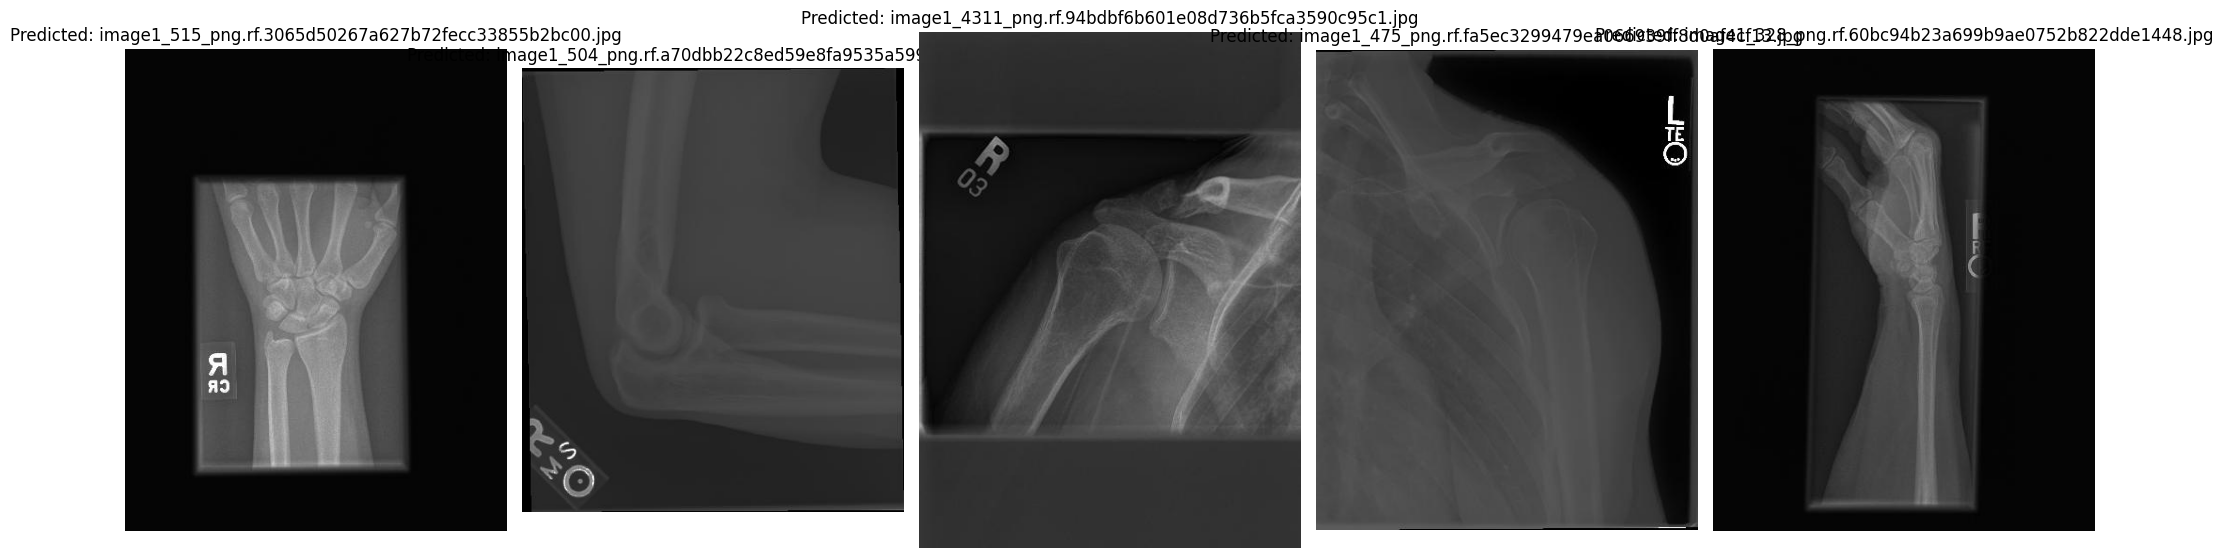


Done with prediction visualization.


In [6]:
TRAINING_RUN_NAME = 'bone_fracture_detection_yolov8n_fast'


run_dir = os.path.join('/kaggle/working/runs', TRAINING_RUN_NAME)

best_model_path = os.path.join(run_dir, 'weights', 'best.pt')


if not os.path.exists(best_model_path):
    print(f"Error: Best model weights not found at {best_model_path}.")
    print("Please ensure the training run completed successfully and generated 'best.pt'.")
    print(f"Expected path: {best_model_path}")
else:
    trained_model = YOLO(best_model_path)

    print("\nVisualizing predictions on validation images...")

    sample_val_images = [os.path.join(processed_dataset_path, 'valid', 'images', f)
                         for f in os.listdir(os.path.join(processed_dataset_path, 'valid', 'images'))
                         if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Ensure there are enough images to sample
    num_samples_to_plot = min(5, len(sample_val_images))
    if num_samples_to_plot == 0:
        print("No validation images found to sample for prediction visualization.")
    else:
        sampled_img_paths = np.random.choice(sample_val_images, num_samples_to_plot, replace=False)

        plt.figure(figsize=(20, 15))
        for i, img_path in enumerate(sampled_img_paths):

            results = trained_model.predict(source=img_path, conf=0.25, iou=0.45, verbose=False)

            ax = plt.subplot(1, num_samples_to_plot, i + 1)
            
            for r in results:
                im_array = r.plot()
                im = Image.fromarray(im_array[..., ::-1])
                plt.imshow(im)
                plt.title(f"Predicted: {os.path.basename(img_path)}")
                plt.axis('off')
        plt.tight_layout()
        plt.show()

    print("\nDone with prediction visualization.")